In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

face_image_path = '/aiffel/image/image.png'
cat_sticker_path = '/aiffel/image/cat-whiskers.png'

face_bgr = cv2.imread(face_image_path)
cat_sticker = cv2.imread(cat_sticker_path)

img_show = face_bgr.copy() # 출력용 이미지
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

In [2]:
# hog detector 를 이용해 얼굴의 bounding box 찾기
detector_hog = dlib.get_frontal_face_detector() # hog detector 선언

dlib_rects = detector_hog(img_show_rgb, 1) # (image, num of image pyramid)

print(dlib_rects)

rectangles[[(345, 98) (531, 284)]]


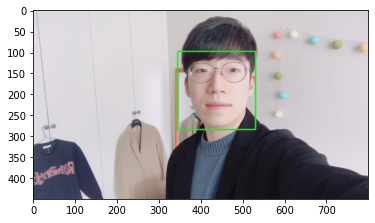

In [3]:
# 얼굴의 bounding box 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_show_rgb)
plt.show()

In [4]:
# 찾을 얼굴의 landmark 를 찍기 위해 모델 가져오기
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

In [5]:
# 얼굴의 landmark 찾아 좌표를 저장
landmarks = list()

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_rgb, dlib_rect) # 얼굴의 landmark 찾기
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    landmarks.append(list_points)
    
print(landmarks[0]) # 얼굴이 1개이기 때문에 0번째 요소를 가져온다

[(367, 155), (367, 175), (371, 196), (375, 216), (382, 236), (390, 252), (403, 267), (419, 278), (440, 280), (462, 276), (481, 266), (496, 251), (508, 234), (515, 215), (519, 194), (521, 173), (521, 151), (376, 132), (384, 120), (398, 116), (413, 118), (424, 124), (451, 122), (464, 114), (479, 111), (493, 114), (502, 125), (438, 143), (437, 156), (437, 169), (437, 182), (423, 198), (431, 199), (439, 200), (446, 199), (454, 197), (391, 147), (399, 143), (408, 143), (416, 148), (408, 150), (399, 150), (463, 147), (472, 142), (481, 141), (488, 145), (481, 149), (472, 148), (411, 227), (421, 222), (431, 218), (439, 221), (447, 219), (458, 222), (470, 227), (458, 235), (447, 238), (438, 238), (430, 238), (420, 236), (415, 228), (431, 227), (439, 228), (447, 227), (465, 227), (446, 228), (438, 229), (431, 228)]


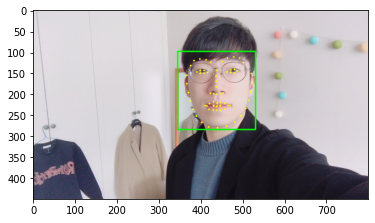

In [6]:
# landmark 에 점 찍기
for landmark in landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 2, (255, 255, 0), -1)
        
plt.imshow(img_show_rgb)
plt.show()

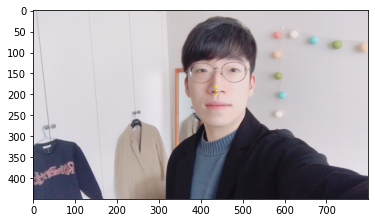

In [7]:
# 적당한 스티커 위치를 찾기 위한 과정
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

point_cat = (landmarks[0][33][0], int(landmarks[0][30][1] + (landmarks[0][33][1] - landmarks[0][30][1]) / 2))

cv2.circle(img_show_rgb, point_cat, 2, (255, 255, 0), -1)
cv2.circle(img_show_rgb, landmarks[0][30], 2, (255, 255, 0), -1)
cv2.circle(img_show_rgb, landmarks[0][33], 2, (255, 255, 0), -1)

plt.imshow(img_show_rgb)

plt.show()

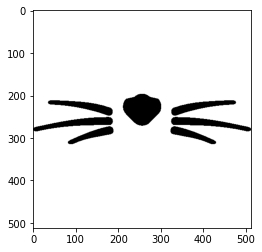

In [8]:
# 스티커의 중앙을 찾아 적당한지 확인
cat_sticker_ = cat_sticker.copy()

# cv2.circle(cat_sticker_, (int(cat_sticker_.shape[0]/2), int(cat_sticker_.shape[0]/2)), 5, (255, 255, 0), -1)

plt.imshow(cat_sticker_)

In [9]:
# 스티커를 붙일 위치와 크기 구하기
for dlib_rect, landmark in zip(dlib_rects, landmarks):
    x = landmark[33][0]
    y = int(landmark[30][1] + (landmark[33][1] - landmark[30][1]) / 3)
    
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(x,y) : (439,188)
(w,h) : (187,187)


In [10]:
# 스티커 사이즈를 얼굴 크기에 맞춰서 조정
cat_sticker = cv2.resize(cat_sticker, (w,h))
print(cat_sticker.shape)

(187, 187, 3)


In [11]:
# 스티커 위치 구하기
refined_x = x - w // 2
refined_y = y - h // 2

In [12]:
if refined_x < 0: 
    cat_sticker = cat_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    cat_sticker = cat_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (346,95)


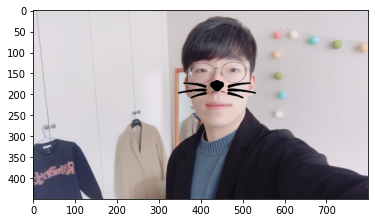

In [13]:
# 스티커와 이미지를 합친다
img_show_ = img_show.copy()

# 이미지 합성을 위해서 스티커가 들어갈 부분을 crop한 이미지를 구한다.
sticker_area = img_show_[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]]

# 스티커가 들어갈 위치에 스티커에서 255 인 부분 즉 흰색인 부분을 모두 crop 한 이미지로 대체한다.
img_show_[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]] = \
    np.where(cat_sticker==255,sticker_area,cat_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show_, cv2.COLOR_BGR2RGB))
plt.show()

스티커를 조금 더 자연스럽게 보이게 하기위해 opencv 의 cv2.addWeighted() 를 사용한다.

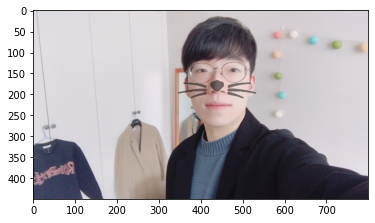

In [14]:
img_show_ = img_show.copy()

sticker_area = img_show_[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]]
img_show_[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(cat_sticker==255,sticker_area,cat_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_show_, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# 다양한 이미지 테스트를 위한 위 과정 모듈화
def find_face(path):
    face = cv2.imread(path)
    
    dlib_rects = bounding_box_(face)
    landmarks = find_landmark_(face, dlib_rects)
    
    if(len(landmarks) == 0):
        print("error: cant find face")
        return 0

    img_show = sticker_set_(face, dlib_rects, landmarks)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return(img_show)

def bounding_box_(img):
    detector_hog = dlib.get_frontal_face_detector()
    
    dlib_rects = detector_hog(img, 1)
    return dlib_rects

def find_landmark_(img, dlib_rects):
    model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    landmarks = list()
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))

        landmarks.append(list_points)

    return landmarks

def sticker_set_(img, dlib_rects, landmarks):
    cat_sticker_path = '/aiffel/image/cat-whiskers.png'
    cat_sticker = cv2.imread(cat_sticker_path)
    
    for dlib_rect, landmark in zip(dlib_rects, landmarks):
        x = landmark[33][0]
        y = int(landmark[30][1] + (landmark[33][1] - landmark[30][1]) / 3)

        w = h = dlib_rect.width()
        
    cat_sticker = cv2.resize(cat_sticker, (w,h))
    
    refined_x = x - w // 2
    refined_y = y - h // 2
    
    if refined_x < 0: 
        cat_sticker = cat_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        cat_sticker = cat_sticker[-refined_y:, :]
        refined_y = 0
        
    sticker_area = img[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]]
    img[refined_y:refined_y+cat_sticker.shape[0], refined_x:refined_x+cat_sticker.shape[1]] = \
        np.where(cat_sticker==255,sticker_area,cat_sticker).astype(np.uint8)
    
    return img

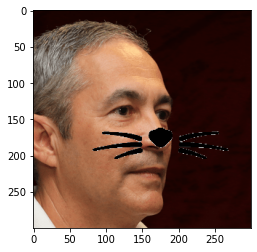

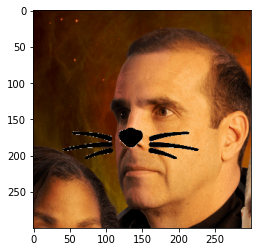

error: cant find face
error: cant find face


0

In [16]:
# image reference(http://referenceangle.com/)
find_face('/aiffel/image/left_angle.jpg')
find_face('/aiffel/image/right_angle.jpg')
find_face('/aiffel/image/top_angle.jpg')
find_face('/aiffel/image/bottom_angle.jpg')

### 4가지 추가적인 이미지를 통해서 테스트를 진행
4가지 각도에서 얼굴 이미지로 테스트를 진행한 결과 2가지 문제점이 보였다.
1. 이미지가 출력은 되지만 스티커는 평면인 반면 얼굴은 각도가 틀어져있어 부자연스럽다.
2. 얼굴을 인식하지 못한다.

위에 두가지 경우에서 우선 1번은 스티커의 각도를 조정해서 해결할 수 있고 2번은 모델을 바꿔 정확성을 향상시켜야겠다.